# GIS Practicum: Energy 
## Citing Optimal EV DCFC Locations in North Carolina
#### Abhishek Sanjay Jain, Duke University Nicholas School of the Environment (aj297@duke.edu) 
Code: Calculate Distance to the nearest charger (#6)

Purpose: We fetch the exits data to understand where can these DCFCs be placed along highway corrdiors to minimize range anxiety to support growth of EVs in North Carolina. 

Methodology:
1. This is done to compute data between an exit and the nearest exisiting DCFC charger. 
2. Import all exits data. 
3. Convert flood zone data CSV into geo data frame. 
4. Create point object with longitude and latitude data pair.
5. Create geodataframe from the point object by specifying the CRS as 
6. We convert our data into the same CRS system. 
7. Create one multipoint geometry object. 
8. Create a function which uses nearest point function and returns the value in miles. 
9. Apply for all exit data, then save into a CSV file. 

In [9]:
#Import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points

In [10]:
exits_gdf = gpd.read_file('../Data/MJBA/Exits.shp')
type(exits_gdf)

geopandas.geodataframe.GeoDataFrame

In [11]:
#Import DCFC csv as a Pandas dataframe, importing only the longitude and latitude columns
dcfc_df = pd.read_csv('../Data/NREL/DCFC.csv',usecols=['longitude','latitude'])

,latitude,longitude
0,35.392063,-80.622777
1,35.042419,-78.956747
2,36.063557,-79.503697
3,35.970518,-78.956848
4,35.261109,-81.139708


In [12]:
#Construct points from long/lat pairs
geom = [Point(xy) for xy in zip(dcfc_df['longitude'],dcfc_df['latitude'])]

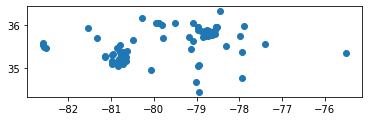

In [13]:
#Convert to a spatial dataframe
dcfc_gdf = gpd.GeoDataFrame(dcfc_df,geometry=geom,crs=4326)
#Show the results
dcfc_gdf.plot();

In [14]:
#Reveal crfs of each
print(exits_gdf.crs)
print(dcfc_gdf.crs)

epsg:4326
epsg:4326


In [15]:
#Transform to a projected crf
exits_gdf = exits_gdf.to_crs(32617)
dcfc_gdf = dcfc_gdf.to_crs(32617)

In [16]:
#Reveal crfs of each: they should be different
print(exits_gdf.crs)
print(dcfc_gdf.crs)

epsg:32617
epsg:32617


In [17]:
#Collapse the dcfc points into one multipoint object
mp_dcfc = dcfc_gdf['geometry'].unary_union

In [21]:
#Put it all together in a function
def distance_to_dcfc(from_point,to_points):
    distance=from_point.distance(nearest_points(from_point,to_points)[1])
    #Convert to miles
    return int(distance/1609.34)

In [22]:
distance_to_dcfc(thePoint,mp_dcfc)

103

In [23]:
exits_gdf['Dist_to_DCFC']=exits_gdf['geometry'].apply(lambda x: distance_to_dcfc(x,mp_dcfc))

,FID,Exit_ID,Longitude,Latitude,County,State,Highway,Type,AADT,Pop_dens,Comm_1mi,Ports_5mi,Ports_10mi,Ports_20mi,Close_nonT,geometry,Dist_to_DCFC
0,7059,US-64_Cherokee_NC_Exit_1,-84.314304,35.019492,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.094152,POINT (197578.012 3880227.389),103
1,7060,US-64_Cherokee_NC_Exit_2,-84.311492,35.014933,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3700,60.34979,1,0,0,0,34.365230,POINT (197817.907 3879713.054),102
2,7061,US-64_Cherokee_NC_Exit_3,-84.295528,35.013561,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,35.233979,POINT (199270.172 3879512.464),102
3,7062,US-64_Cherokee_NC_Exit_4,-84.280291,35.012880,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.048303,POINT (200658.638 3879391.092),101
4,7063,US-64_Cherokee_NC_Exit_5,-84.275190,35.017816,Cherokee,NC,U.S. Highway 64,Exit/Intersection,3900,60.34979,0,0,0,0,36.186597,POINT (201142.266 3879923.503),100


In [25]:
exits_gdf.to_file('../Data/Processed/Exits_distance_to_DCFC.shp')